In [1]:
%matplotlib widget

import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.shifting import computeShifting
import numpy as np
import torch

from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

# def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     sc = axis.scatter(pos[:,0], pos[:,1], s = 8, c = c)
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
#     axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

# def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

#     sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = 8, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'Spectral')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(-1.05,1.05)
#     axis.set_ylim(-1.05,1.05)

In [2]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.plotting import plotImplicitSDF
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorFieldGradient
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 64
    },
    'kernel':{
        'name': 'Wendland2',
    'targetNeighbors': 45.22,
    },
    "neighborhood":{
        "scheme": "compact"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    },
    'shifting':{
        'freeSurface': True
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.]),
  'maxExtent': tensor([1., 1.]),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True])},
 'particle': {'nx': 64,
  'dx': tensor(0.0312),
  'kernelScale': tensor(1.8970),
  'defaultVolume': tensor(0.0010),
  'defaultSupport': 0.11856059341027234,
  'volume': tensor(0.0010),
  'support': 0.11856059341027234,
  'smoothingLength': tensor(0.0625)},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 45.22,
  'function': <diffSPH.kernels.KernelWrapper at 0x758703398d10>,
  'kernelScale': tensor(1.8970)},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'shifting': {'freeSurface': True,
  'scheme': 'deltaSPH',
  'R': 0.25,
  'n': 4,
  'CFL': 1.5,
  'computeMach': True,
  'solver': 'BiCGStab_wJacobi',
  'normalScheme': 'lambda',
  'projectionScheme': 'mat',
  'threshold': 0.5,
  'surfaceScaling': 0.1,
  'm

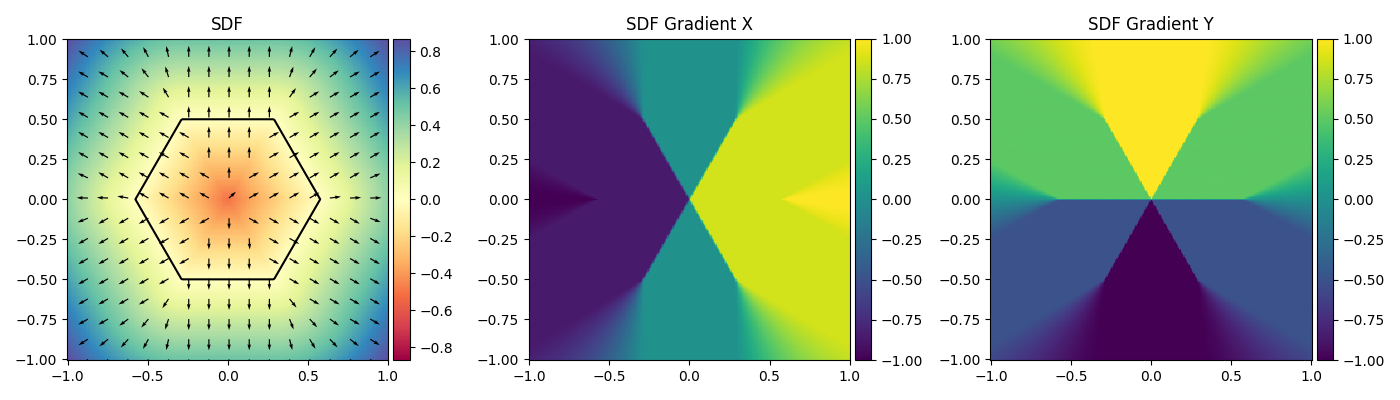

In [3]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [4]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs

fluidState,_ = sampleParticles(config)
boundaryState = processBoundarySDFs(fluidState, config, [sdf], 'sdf')

# display(boundaryState)

particleState = {
    'fluid': fluidState,
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

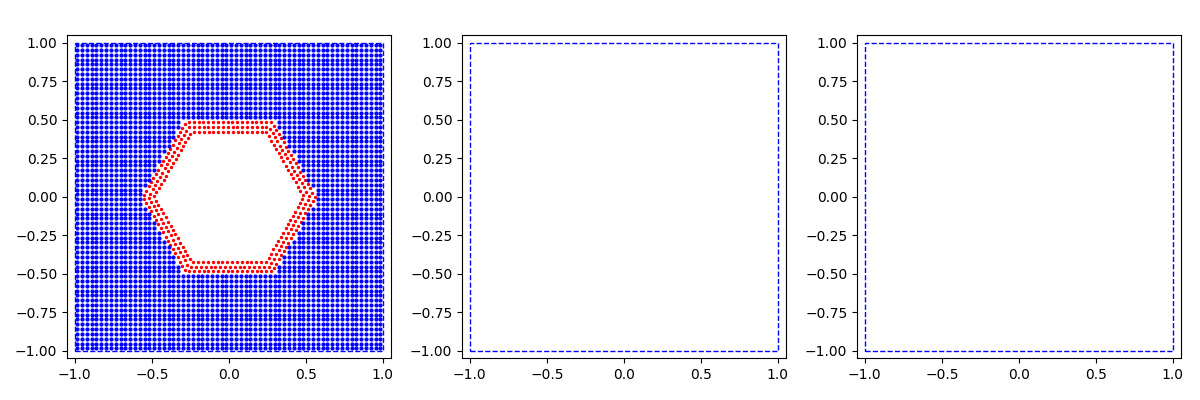

In [5]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

for ax in axis.flatten():    
    domainMin = config['domain']['minExtent']
    domainMax = config['domain']['maxExtent']
    square = patches.Rectangle((domainMin[0].detach().cpu().numpy(), domainMin[1].detach().cpu().numpy()), domainMax[0].detach().cpu().numpy() - domainMin[0].detach().cpu().numpy(), domainMax[1].detach().cpu().numpy() - domainMin[1].detach().cpu().numpy(), linewidth=1, edgecolor='b', facecolor='none',ls='--')
    ax.add_patch(square)
    ax.set_aspect('equal')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)

axis[0,0].scatter(particleState['boundary']['positions'][:,0].detach().cpu().numpy(), particleState['boundary']['positions'][:,1].detach().cpu().numpy(), c = 'red', s = 2)
axis[0,0].scatter(particleState['fluid']['positions'][:,0].detach().cpu().numpy(), particleState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', s = 4)

# scatterPlotSymmetric(fig, axis[0,0], boundaryParticles, boundaryParticles.new_ones(boundaryParticles.shape[0]), config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
# scatterPlotSymmetric(fig, axis[0,1], boundaryParticles, boundaryNormals[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
# scatterPlotSymmetric(fig, axis[0,2], boundaryParticles, boundaryNormals[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8, cbar = False)

fig.tight_layout()

In [6]:
initialPositions = particleState['fluid']['positions'].clone()

In [7]:
for fKey in particleState['fluid'].keys():
    print(fKey, particleState['fluid'][fKey] if not isinstance(particleState['fluid'][fKey], torch.Tensor) else f'{particleState["fluid"][fKey].shape} {particleState["fluid"][fKey].dtype}')

for bKey in particleState['boundary'].keys():
    print(bKey, particleState['boundary'][bKey] if not isinstance(particleState['boundary'][bKey], torch.Tensor) else f'{particleState["boundary"][bKey].shape} {particleState["boundary"][bKey].dtype}')


numParticles 3208
positions torch.Size([3208, 2]) torch.float32
areas torch.Size([3208]) torch.float32
pressures torch.Size([3208]) torch.float32
divergence torch.Size([3208]) torch.float32
masses torch.Size([3208]) torch.float32
supports torch.Size([3208]) torch.float32
index torch.Size([3208]) torch.int64
densities torch.Size([3208]) torch.float32
velocities torch.Size([3208, 2]) torch.float32
accelerations torch.Size([3208, 2]) torch.float32
numNeighbors torch.Size([3208]) torch.int64
neighborhood {'indices': (tensor([   0,    0,    0,  ..., 4095, 4095, 4095]), tensor([4095, 4093, 4094,  ...,   65,   66,    2])), 'fullIndices': (tensor([   0,    0,    0,  ..., 4095, 4095, 4095]), tensor([4095, 4092, 4093,  ...,   67,    2,    3])), 'distances': tensor([0.3728, 0.8335, 0.5894,  ..., 0.7455, 0.9503, 0.8335]), 'vectors': tensor([[ 0.7071,  0.7071],
        [ 0.9487,  0.3162],
        [ 0.8944,  0.4472],
        ...,
        [-0.7071, -0.7071],
        [-0.8320, -0.5547],
        [-0.94

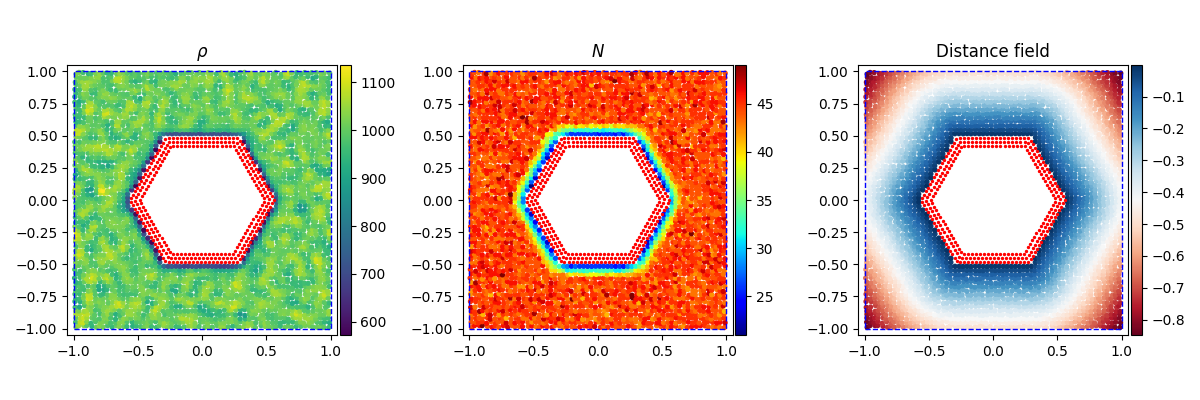

In [8]:

particleState['fluid']['positions'] = initialPositions.clone() 
jitter = torch.rand(particleState['fluid']['positions'].shape) * config['particle']['dx'] - config['particle']['dx'] * 0.5
jitter = jitter *  torch.clamp(torch.abs(particleState['fluid']['distances'][:,None]) / config['particle']['support'], 0, 1)


particleState['fluid']['positions'] += jitter * 0.5

_, particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Distance field', cmap = 'RdBu', s = 8)

for ax in axis.flatten():
    ax.scatter(particleState['boundary']['positions'][:,0].detach().cpu().numpy(), particleState['boundary']['positions'][:,1].detach().cpu().numpy(), c = 'red', s = 2)

fig.tight_layout()


In [9]:
config['shifting']

{'freeSurface': True,
 'scheme': 'deltaSPH',
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'threshold': 0.5,
 'surfaceScaling': 0.1,
 'maxIterations': 1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True,
 'tol': 0.0001,
 'rtol': 0.0001,
 'preconditioner': 'Jacobi',
 'verbose': False,
 'solverThreshold': tensor(0.0156)}

BiCGStab Solver
Initial Residual: 133.32191467285156, Threshold 0.0001
atol: 0.013332191467285157 [0.0001]
rhotol: 1.4210854715202004e-14 | omegatol: 1.4210854715202004e-14
Initial Residual: 198.45896911621094
	[  0]	Residual: 27.611692428588867 | rho: 39385.96875 | alpha: 0.0014591693179681897 | omega: 0.0014956711092963815
	[  1]	Residual: 10.008805274963379 | rho: 2973.478515625 | alpha: 0.0022603864781558514 | omega: 0.0018017421243712306
	[  2]	Residual: 3.96757173538208 | rho: 629.8958129882812 | alpha: 0.002436848822981119 | omega: 0.001612572348676622
	[  3]	Residual: 1.8849650621414185 | rho: 115.33814239501953 | alpha: 0.0023484560661017895 | omega: 0.002079450525343418
	[  4]	Residual: 1.0036044120788574 | rho: 28.113677978515625 | alpha: 0.0024744761176407337 | omega: 0.0016176992794498801
	[  5]	Residual: 0.544401228427887 | rho: 6.424694538116455 | alpha: 0.0025544671807438135 | omega: 0.0023170653730630875
	[  6]	Residual: 0.29791903495788574 | rho: 2.193459987640381 | a

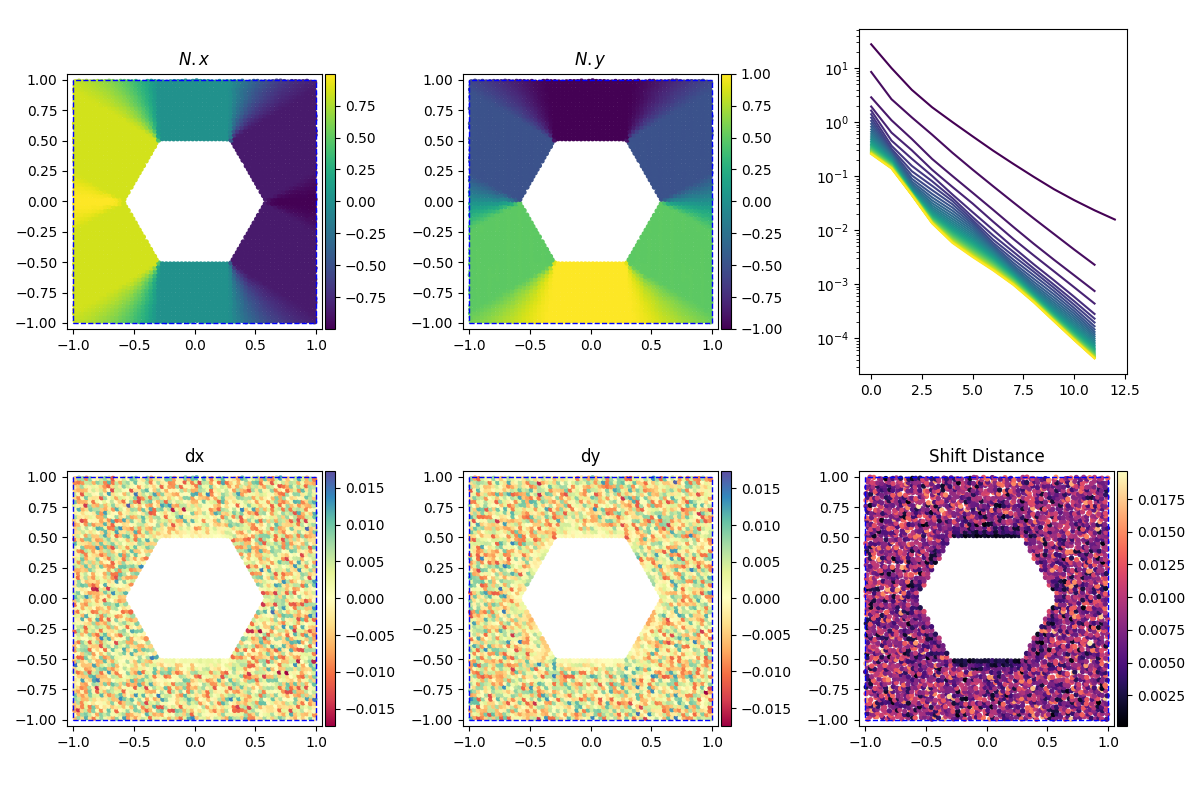

In [10]:
from diffSPH.v2.modules.shifting import solveShifting
config['shifting']['scheme'] = 'IPS'
# config['shifting']['scheme'] = 'delta'
config['shifting']['computeMach'] = False
config['shifting']['maxIterations'] = 32
config['shifting']['solver'] = 'BiCG'
config['shifting']['normalScheme'] = 'lambda'
config['shifting']['freeSurface'] = False
config['shifting']['useExtendedMask'] = False
config['shifting']['projectionScheme'] = 'mat'
config['shifting']['surfaceScaling'] = 1.
config['shifting']['surfaceDetection'] = 'colorGrad'
config['shifting']['summationDensity'] = False
config['shifting']['surfaceDetection'] = 'Maronne'
config['shifting']['surfaceDetection'] = 'Barcasco'
config['shifting']['initialization'] = 'deltaPlus'
config['shifting']['threshold'] = 0.05
config['shifting']['verbose'] = True
config['surfaceDetection']['expansionIterations'] = 2
config['shifting']['solverThreshold'] = 0.0156
config['shifting']['threshold'] = 0.5
config['shifting']['preconditioner'] = 'Jacobi'

import matplotlib.colors as mcolors


fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter* 0.75
_, particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)

positions = torch.clone(particleState['fluid']['positions'])
particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['densities']) * config['fluid']['rho0']

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

_, particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['normals'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$N.x$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['normals'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$N.y$', cmap = 'viridis', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Num Neighbors', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    if len(cs[i]) < 2:
        axis[0,2].scatter(np.arange(len(cs[i])), cs[i], label = f'iter {i}', c = mappable.to_rgba(i))
    else:
        axis[0,2].plot(np.arange(len(cs[i])), cs[i], c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

# for ax in axis.flatten():
#     ax.axvline(-0.5, c = 'k', ls = '--')
#     ax.axvline(0.5, c = 'k', ls = '--')
#     ax.axhline(-0.5, c = 'k', ls = '--')
#     ax.axhline(0.5, c = 'k', ls = '--')
    


# for ax in axis.flatten():
    # ax.scatter(particleState['boundary']['positions'][:,0].detach().cpu().numpy(), particleState['boundary']['positions'][:,1].detach().cpu().numpy(), c = 'red', s = 2)


fig.tight_layout()

In [26]:
from torch.autograd.profiler import record_function
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco, computeNormalsMaronne, detectFreeSurfaceMaronne, expandFreeSurfaceMask, computeColorField, computeColorFieldGradient, detectFreeSurfaceColorFieldGradient
# from diffSPH.v2.modules.shifting import computeLambdaGrad, deltaPlusShifting, computeShifting, BiCGStab_wJacobi, BiCG, LinearCG, BiCGStab

from diffSPH.v2.sparse import bicg, bicgstab, cg
def solveShifting(simulationState, config):
    with record_function("[Shifting] - Compute Shift Amount"):
        numParticles = simulationState['fluid']['numParticles']
        fluidState = simulationState['fluid']
        boundaryParticleState = simulationState['boundary'] if 'boundary' in simulationState else None

        mergedPositions = torch.cat((fluidState['positions'], boundaryParticleState['positions']), dim = 0) if boundaryParticleState is not None else fluidState['positions']
        mergedVelocities = torch.cat((fluidState['velocities'], boundaryParticleState['velocities']), dim = 0) if boundaryParticleState is not None else fluidState['velocities']
        mergedMasses = torch.cat((fluidState['masses'], boundaryParticleState['masses']), dim = 0) if boundaryParticleState is not None else fluidState['masses']
        mergedAreas = torch.cat((fluidState['areas'], boundaryParticleState['areas']), dim = 0) if boundaryParticleState is not None else fluidState['areas']
        mergedDensities = torch.cat((fluidState['densities'], boundaryParticleState['densities']), dim = 0) if boundaryParticleState is not None else fluidState['densities']
        mergedSupports = torch.cat((fluidState['supports'], boundaryParticleState['supports']), dim = 0) if boundaryParticleState is not None else fluidState['supports']
        boundaryMarker = torch.cat((torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32), torch.ones(boundaryParticleState['positions'].shape[0], dtype = torch.int32))) if boundaryParticleState is not None else torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32)
        
        particleState = {
            'positions': mergedPositions,
            'velocities': mergedVelocities,
            'masses': mergedMasses,
            'densities': mergedDensities,
            'supports': mergedSupports,
            'areas': mergedAreas,
            'numParticles': mergedPositions.shape[0],
            'boundaryMarker': boundaryMarker
        }
        if 'neighborhood' in simulationState['fluid']:
            particleState['neighborhood'] = simulationState['fluid']['neighborhood']

        initialPositions = torch.clone(particleState['positions'])
        initialDensities = torch.clone(particleState['densities'])
        overallStates = []
        for i in range(config['shifting']['maxIterations']):
            with record_function("[Shifting] - Shift Iteration [Iteration: %3d]" % i):
                with record_function("[Shifting] - Shift Iteration [1 - Neighbor Search]"):
                    particleState['datastructure'], particleState['neighborhood'] = neighborSearch(particleState, particleState, config, 
                        computeKernels = True, 
                        priorState = None if 'neighborhood' not in particleState else particleState['neighborhood'],
                        neighborDatastructure = None if 'datastructure' not in particleState else particleState['datastructure'],
                        verbose = False)
                    particleState['numNeighbors'] = particleState['neighborhood']['numNeighbors']
                
                    
                    # particleState['neighborhood'] = neighborSearch(particleState, particleState, config, priorNeighborhood=particleState['neighborhood'] if 'neighborhood' in particleState else None)
                if config['shifting']['summationDensity']:
                    particleState['densities'] = sphOperationStates(particleState, particleState, None, operation = 'density', neighborhood=particleState['neighborhood'])

                with record_function("[Shifting] - Shift Iteration [2 - Surface Detection]"):
                    if config['shifting']['freeSurface']:
                        if config['shifting']['surfaceDetection'] == 'Maronne':
                            particleState['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState, particleState, particleState['neighborhood'], config)
                            particleState['normals'], particleState['Lambdas'] = computeNormalsMaronne(particleState, particleState, particleState['neighborhood'], config)
                            particleState['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState, particleState, particleState['neighborhood'], config)
                        elif config['shifting']['surfaceDetection'] == 'colorGrad':
                            particleState['color'] = computeColorField(particleState, particleState, particleState['neighborhood'], config)
                            particleState['colorGradient'] = computeColorFieldGradient(particleState, particleState, particleState['neighborhood'], config)
                            particleState['freeSurface'] = detectFreeSurfaceColorFieldGradient(particleState, particleState, particleState['neighborhood'], config)
                        elif config['shifting']['surfaceDetection'] == 'Barcasco':
                            particleState['freeSurface'] = detectFreeSurfaceBarecasco(particleState, particleState, particleState['neighborhood'], config)
                                        
                        particleState['freeSurfaceMask'] = expandFreeSurfaceMask(particleState, particleState, particleState['neighborhood'], config)
                return particleState
    
shiftState = solveShifting(particleState, config)

In [28]:
from diffSPH.v2.modules.shifting import evalKernel, getShiftingMatrices

numParticles = shiftState['numParticles']

if config['shifting']['freeSurface']:  
    if config['shifting']['useExtendedMask']:
        fs = shiftState['freeSurfaceMask']
    else:
        fs = shiftState['freeSurface']
    fsm = shiftState['freeSurfaceMask']

# particleState['fluidNeighborhood'] = fluidNeighborSearch(particleState, config)
(i,j) = shiftState['neighborhood']['indices']
rij = shiftState['neighborhood']['distances']
xij = shiftState['neighborhood']['vectors']
hij = shiftState['neighborhood']['supports']
k = config['kernel']['function']
dim = config['domain']['dim']

K, J, H = evalKernel(rij, xij, hij, k, dim)

H, B, x0, i, j, activeMask = getShiftingMatrices(shiftState, config, computeRho = True)

In [29]:
activeMask

tensor([ True,  True,  True,  ..., False, False, False])

In [31]:
B.view(-1,2)[shiftState['boundaryMarker'] > 0]

tensor([[ 0.0000e+00, -8.5856e+00],
        [ 0.0000e+00, -3.9845e+00],
        [ 0.0000e+00, -9.5884e-01],
        [ 0.0000e+00, -6.2930e+00],
        [ 0.0000e+00, -8.1249e+00],
        [ 0.0000e+00, -5.0076e+00],
        [ 0.0000e+00,  6.6165e-01],
        [ 0.0000e+00,  2.5705e+00],
        [ 0.0000e+00, -4.8030e+00],
        [ 0.0000e+00, -6.9277e+00],
        [ 0.0000e+00,  7.2574e-01],
        [ 0.0000e+00,  3.5867e+00],
        [ 0.0000e+00, -2.4577e+00],
        [ 0.0000e+00, -7.3363e+00],
        [ 0.0000e+00, -2.6299e+00],
        [ 0.0000e+00,  3.3430e+00],
        [ 0.0000e+00, -2.0730e+00],
        [ 0.0000e+00, -5.3131e+00],
        [ 0.0000e+00, -2.3592e+00],
        [ 0.0000e+00, -4.9934e-01],
        [ 0.0000e+00, -2.7584e+00],
        [ 0.0000e+00, -5.6016e+00],
        [ 0.0000e+00, -3.9293e+00],
        [ 0.0000e+00,  1.1317e-01],
        [ 0.0000e+00,  3.6602e-02],
        [ 0.0000e+00, -4.4260e+00],
        [ 0.0000e+00, -4.5583e+00],
        [ 0.0000e+00, -1.978

In [ ]:
ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)
sdf = sphere_b

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)

plotImplicitSDF(sdf, ngrid = 255, minExtent = -1, maxExtent = 1)

In [ ]:
from diffSPH.v2.sampling import sampleParticles
import copy
fluidState, mask = sampleParticles(config, sdfs = [sdf])
particleState = {'fluid': fluidState, 'time': 0.0, 'timestep': 0, 'dt': config['timestep']['dt']}
initialState = copy.deepcopy(particleState)

# for k in particleState.keys():
    # if isinstance(particleState['fluid'][k], torch.Tensor):
        # particleState[k] = particleState[k][mask]
particleState['numParticles'] = particleState['fluid']['positions'].shape[0]
initialPositions = torch.clone(particleState['fluid']['positions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Distance field', cmap = 'RdBu', s = 8)

fig.tight_layout()

In [ ]:
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne, expandFreeSurfaceMask, computeColorField, detectFreeSurfaceBarecasco, computeColorFieldGradient, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.shifting import computeLambdaGrad, deltaPlusShifting, computeShifting, BiCGStab_wJacobi, BiCG, LinearCG, BiCGStab

particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['areas']) * ( config['fluid']['rho0'])
# particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')

particleState['fluid']['color'] = computeColorField(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
# particleState['fluid']['densities'][:] = config['fluid']['rho0']
particleState['fluid']['colorGradient'] = computeColorFieldGradient(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
config['surfaceDetection']['colorFieldGradientThreshold'] = 10.0
fs = detectFreeSurfaceColorFieldGradient(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['L'], normalizationMatrices, particleState['fluid']['L.EVs'] = computeNormalizationMatrices(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['normals'], particleState['fluid']['Lambdas'] = computeNormalsMaronne(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['freeSurface'] = detectFreeSurfaceBarecasco(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['freeSurfaceMask'] = expandFreeSurfaceMask(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
# particleState['fluid']['freeSurface'] = particleState['fluid']['Lambdas'] < 0.4

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['color'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field', cmap = 'viridis', s = 1)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient x', cmap = 'RdBu', s = 1)
scatterPlot(fig, axis[1,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient y', cmap = 'RdBu', s = 1)
scatterPlot(fig, axis[1,0], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Free Surface', cmap = 'viridis', s = 1)

scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], cA, config['domain']['minExtent'], config['domain']['maxExtent'], 'ConditionA', cmap = 'viridis', s = 1)
scatterPlot(fig, axis[1,2], particleState['fluid']['positions'], cB, config['domain']['minExtent'], config['domain']['maxExtent'], 'Condition B', cmap = 'viridis', s = 1)

fig.tight_layout()

In [7]:
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne, expandFreeSurfaceMask


In [8]:


# particleState['fluid']['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState, config)
# particleState['fluid']['normals'], lMin = computeNormalsMaronne(particleState, config)
# particleState['fluid']['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState, config)
# particleState['fluid']['freeSurfaceMask'] = expandFreeSurfaceMask(particleState, config)

# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['freeSurfaceMask'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface mask', cmap = 'viridis', s = 8)
# scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['normals'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$N.x$', cmap = 'RdBu', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['normals'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$N.y$', cmap = 'RdBu', s = 8)
# fig.tight_layout()


In [9]:
from diffSPH.v2.shifting import BiCGStab, LinearCG, evalKernel


In [ ]:

particleState['fluid']['positions'] = initialPositions.clone() 
jitter = torch.rand(particleState['fluid']['positions'].shape) * config['particle']['dx'] - config['particle']['dx'] * 0.5
jitter = jitter *  torch.clamp(torch.abs(particleState['fluid']['distances'][:,None]) / config['particle']['support'], 0, 1)


particleState['fluid']['positions'] += jitter * 0.5

particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Distance field', cmap = 'RdBu', s = 8)

fig.tight_layout()


In [ ]:
from diffSPH.v2.modules.shifting import solveShifting
config['shifting']['scheme'] = 'IPS'
config['shifting']['scheme'] = 'delta'
config['shifting']['computeMach'] = False
config['shifting']['maxIterations'] = 32
config['shifting']['solver'] = 'BiCGStab_wJacobi'
config['shifting']['normalScheme'] = 'lambda'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False
config['shifting']['projectionScheme'] = 'mat'
config['shifting']['surfaceScaling'] = 1.
config['shifting']['surfaceDetection'] = 'colorGrad'
config['shifting']['summationDensity'] = False
config['shifting']['surfaceDetection'] = 'Maronne'
config['shifting']['surfaceDetection'] = 'Barcasco'
config['shifting']['initialization'] = 'zero'
config['shifting']['threshold'] = 0.05
config['surfaceDetection']['expansionIterations'] = 2



fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter* 0.75

positions = torch.clone(particleState['fluid']['positions'])
particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['densities']) * config['fluid']['rho0']

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['normals'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['normals'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

# cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
# norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
# mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
# for i in range(len(cs)):
#     axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

# axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

for ax in axis.flatten():
    ax.axvline(-0.5, c = 'k', ls = '--')
    ax.axvline(0.5, c = 'k', ls = '--')
    ax.axhline(-0.5, c = 'k', ls = '--')
    ax.axhline(0.5, c = 'k', ls = '--')
    
fig.tight_layout()

In [ ]:
# torch.linalg.norm(B)

In [23]:
numParticles = particleState['fluid']['positions'].shape[0]
if config['shifting']['freeSurface']:  
    if config['shifting']['useExtendedMask']:
        fs = particleState['fluid']['freeSurfaceMask']
    else:
        fs = particleState['fluid']['freeSurface']
    fsm = particleState['fluid']['freeSurfaceMask']

# particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
(i,j) = particleState['fluid']['neighborhood']['indices']
rij = particleState['fluid']['neighborhood']['distances']
xij = particleState['fluid']['neighborhood']['vectors']
hij = particleState['fluid']['neighborhood']['supports']
k = config['kernel']['function']
dim = config['domain']['dim']

K, J, H = evalKernel(rij, xij, hij, k, dim)
# if computeRho:
    # particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
    # omega =  particleState['fluidMasses'] / particleState['fluid']['densities']
# else:
omega = particleState['fluid']['areas']


J = scatter_sum(J * omega[j,None], i, dim = 0, dim_size = numParticles)
# H = H * omega[j,None,None]

h2 = particleState['fluidSupports'].repeat(2,1).T.flatten()
x0 = torch.rand(numParticles * 2).to(rij.device).type(rij.dtype) * h2 / 4 - h2 / 8
if config['shifting']['initialization'] == 'deltaPlus':
    x0 = -deltaPlusShifting(particleState, config).flatten() * 0.5
if config['shifting']['initialization'] == 'deltaMinus':
    x0 = deltaPlusShifting(particleState, config).flatten() * 0.5
if config['shifting']['initialization'] == 'zero':
    x0 = torch.zeros_like(x0)


B = torch.zeros(numParticles * 2, dtype = torch.float32, device=rij.device)
if config['shifting']['freeSurface']:

    J2 = torch.zeros(J.shape[0], 2, dtype = torch.float32, device=rij.device)
    J2[fs < 0.5, :] = J[fs < 0.5, :]

    B[::2] = J2[:,0]
    B[1::2] = J2[:,1]

In [ ]:

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

scatterPlotSymmetric(fig, axis[0,0], particleState['fluid']['positions'], B[::2], config['domain']['minExtent'], config['domain']['maxExtent'], 'J.x', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], B[1::2], config['domain']['minExtent'], config['domain']['maxExtent'], 'J.y', cmap = 'Spectral', s = 8)

Hs = scatter_sum(H * omega[j,None, None], i, dim = 0, dim_size = numParticles)
scatterPlotSymmetric(fig, axis[0,1], particleState['fluid']['positions'], Hs[:,0,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'H.xx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], particleState['fluid']['positions'], Hs[:,0,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'H.xy', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], Hs[:,1,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'H.yy', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,2], particleState['fluid']['positions'], Hs[:,1,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'B', cmap = 'Spectral', s = 8)


fig.tight_layout()

In [29]:
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco

In [ ]:
particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['areas']) * ( config['fluid']['rho0'])
# particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')

particleState['fluid']['color'] = computeColorField(particleState, config)
# particleState['fluid']['densities'][:] = config['fluid']['rho0']
particleState['fluid']['colorGradient'] = computeColorFieldGradient(particleState, config)
config['surfaceDetection']['colorFieldGradientThreshold'] = 10.0
fs = detectFreeSurfaceColorFieldGradient(particleState, config)
particleState['fluid']['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState, config)
particleState['fluid']['normals'], particleState['fluid']['Lambdas'] = computeNormalsMaronne(particleState, config)
particleState['fluid']['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState, config)
particleState['fluid']['freeSurface'] = detectFreeSurfaceBarecasco(particleState, config)
particleState['fluid']['freeSurfaceMask'] = expandFreeSurfaceMask(particleState, config)
# particleState['fluid']['freeSurface'] = particleState['fluid']['Lambdas'] < 0.4

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient x', cmap = 'RdBu', s = 8)
scatterPlot(fig, axis[1,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient y', cmap = 'RdBu', s = 8)
scatterPlot(fig, axis[1,0], particleState['fluid']['positions'], particleState['fluid']['Lambdas'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Free Surface', cmap = 'viridis', s = 8)

scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], cA, config['domain']['minExtent'], config['domain']['maxExtent'], 'ConditionA', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[1,2], particleState['fluid']['positions'], cB, config['domain']['minExtent'], config['domain']['maxExtent'], 'Condition B', cmap = 'viridis', s = 8)

fig.tight_layout()

In [ ]:
torch.min(particleState['L.EVs'], dim = 0)

In [ ]:
particleState['fluid']['densities']

In [ ]:
config['shifting']['scheme'] = 'IPS'
config['shifting']['maxIterations'] = 4
config['shifting']['solver'] = 'BiCGStab'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

fig.tight_layout()

In [ ]:
config['shifting']['scheme'] = 'IPS'
config['shifting']['maxIterations'] = 4
config['shifting']['solver'] = 'LinearCG'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

fig.tight_layout()

In [ ]:
config['shifting']['scheme'] = 'deltaPlus'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

dx = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

fig.tight_layout()

In [ ]:
config['shifting']['scheme'] = 'IPS'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

# dx = solveShifting(particleState, config)
# particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            dx = solveShifting(particleState, config)
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")